### ECE 572 Course Project - Cool Fancy-Dancy Name Here

Project Description:
Python-based program designed to extract and visualize network traffic information from a Wireshark generated .csv file. 

Team Members:

Devang Sharma - V00931210 - devsharma@uvic.ca

Alex Spurgeon - V00818626 - aespurge@uvic.ca

Aditya Naren Yerramilli - V00938179 - naren1@uvic.ca


#### Useful Resources for this project:

General References:

Pandas: https://nbviewer.jupyter.org/gist/manujeevanprakash/996d18985be612072ee0
https://pandas.pydata.org/pandas-docs/stable/getting_started/dsintro.html

Mix of everything: https://www.analyticsvidhya.com/blog/2016/01/complete-tutorial-learn-data-science-python-scratch-2/

Examples of analysis:
https://null-byte.wonderhowto.com/how-to/analyze-wi-fi-data-captures-with-jupyter-notebook-0201490/

https://github.com/skickar/Research/blob/master/RedLineResearch.ipynb

https://medium.com/hackervalleystudio/learning-packet-analysis-with-data-science-5356a3340d4e

https://github.com/secdevopsai/Packet-Analytics/blob/master/Packet-Analytics.ipynb

(Some minor examples here) https://www.python4networkengineers.com/posts/wireshark/analyzing_wireshark_data_with_pandas/

In [1]:
# Imports and essentials
import numpy as np
import pandas as pd
from pandas import plotting
import matplotlib.pyplot as plt
import datetime
import re
import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline

# 1) ECE572Test

In [2]:
# Import data from csv files - ECE572Test.csv, ECE572Test.csv, & ECE572DoS.csv
test_df = pd.read_csv('ECE572Test_n.csv', 
                 delimiter = ',', encoding='latin-1', header=0) # Header labels all in row = 0 

## Cleanup

In [3]:
test_df = test_df.fillna(0)

test_df = test_df.drop(columns="No.")

#print(test_df.head())

print(test_df[["Source", "Source Port", 
               "Destination", "Dest Port", "Protocol"]].head(10)) #print only required data

print("\nDataset dimensions", test_df.shape)

              Source  Source Port        Destination  Dest Port Protocol
0     192.168.56.102        137.0     192.168.56.255      137.0     NBNS
1     192.168.56.101        137.0     192.168.56.102      137.0     NBNS
2       192.168.56.1      54926.0    255.255.255.255      137.0     NBNS
3     192.168.56.101        137.0       192.168.56.1    54926.0     NBNS
4  PcsCompu_ae:93:92          0.0  PcsCompu_af:7b:18        0.0      ARP
5  PcsCompu_ae:93:92          0.0  0a:00:27:00:00:1a        0.0      ARP
6  0a:00:27:00:00:1a          0.0  PcsCompu_ae:93:92        0.0      ARP
7  PcsCompu_af:7b:18          0.0  PcsCompu_ae:93:92        0.0      ARP
8     192.168.56.102      60348.0     192.168.56.101       22.0      TCP
9     192.168.56.101         22.0     192.168.56.102    60348.0      TCP

Dataset dimensions (9184, 8)


## Network Graph

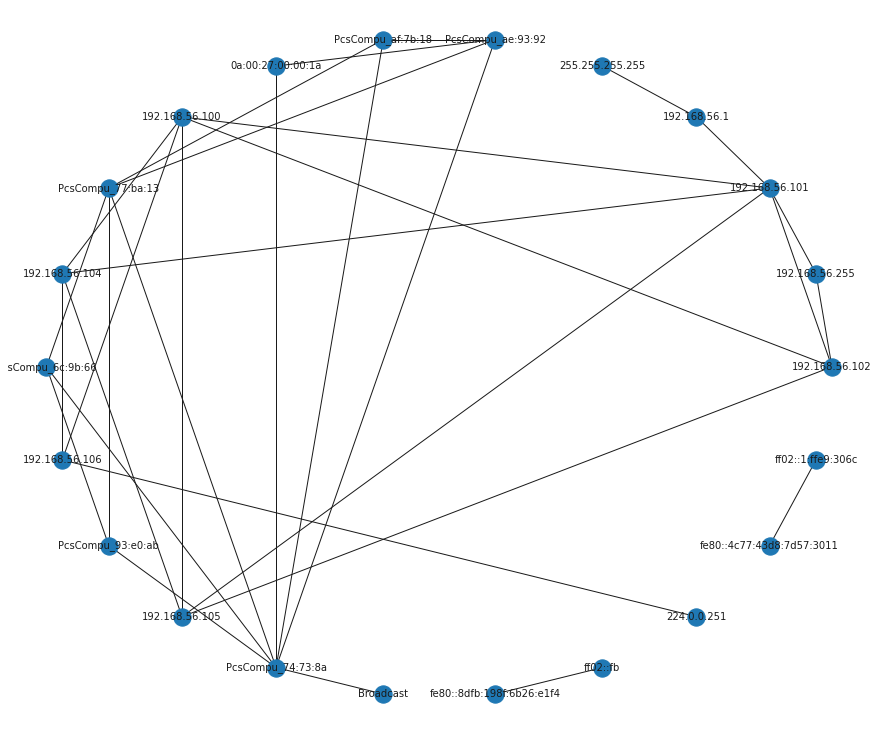

In [4]:
#https://towardsdatascience.com/from-dataframe-to-network-graph-bbb35c8ab675
import networkx as nx
network_graph = nx.from_pandas_edgelist(test_df, 'Source', 'Destination')
from matplotlib.pyplot import figure
figure(figsize=(12, 10))
nx.draw_shell(network_graph, with_labels=True, font_size=10)

## Statistics

In [5]:
def df_to_num(unique_df=None):
    num_unique_df = pd.Series([])
    i = -1
    for val in unique_df:
        if not (re.search('[a-zA-Z]', val)):
            i+=1
            num_unique_df.loc[i] = val
    return num_unique_df

### Top level view of the Test PCap

In [6]:
# Source Adddress with the highest amount of data transfer
print("# Source Address with the highest amount of data transfer")
print(test_df['Source'].describe(),'\n\n')

# Destination Address with the highest amount of data transfer
print("# Destination with the highest amount of data transfer")
print(test_df['Destination'].describe(),'\n\n')

frequent_address = test_df['Source'].describe()['top']

# Destination address to which most of the connections/data transfers are made
print("# Destination address receiving most amount of data")
print(test_df[test_df['Source'] == frequent_address]['Destination'].unique(),"\n\n")

# Most frequently used destination port by top source address (dst ports)
print("# Most frequently used Destination ports by top source address (Destination Ports)")
print((test_df[test_df['Source'] == frequent_address]['Dest Port'].unique()),"\n\n")

# Most frequently used source port by top source address(src ports)
print("# Most frequently used source ports by top source address (Source ports)")
print(test_df[test_df['Source'] == frequent_address]['Source Port'].unique(),"\n\n")

# Source Address with the highest amount of data transfer
count               9184
unique                16
top       192.168.56.105
freq                3884
Name: Source, dtype: object 


# Destination with the highest amount of data transfer
count               9184
unique                20
top       192.168.56.105
freq                4153
Name: Destination, dtype: object 


# Destination address receiving most amount of data
['192.168.56.100' '192.168.56.104' '192.168.56.102' '192.168.56.101'] 


# Most frequently used Destination ports by top source address (Destination Ports)
[6.7000e+01 2.3000e+01 1.4300e+02 2.5000e+01 1.9900e+02 1.7230e+03
 2.1000e+01 9.9500e+02 1.3900e+02 8.0800e+03 9.9300e+02 1.7200e+03
 4.4500e+02 1.0250e+03 1.1000e+02 1.3500e+02 8.0000e+01 4.4300e+02
 3.3890e+03 8.8880e+03 5.3000e+01 5.8700e+02 3.3060e+03 1.1100e+02
 5.9000e+03 1.1300e+02 5.5400e+02 2.2000e+01 1.9000e+03 1.0000e+04
 8.0090e+03 5.6310e+03 5.4300e+02 3.1280e+03 8.8000e+01 5.1400e+02
 8.0810e+0

### Deep analysis of Source Stats

In [7]:
# Unique Source Addresses
print("Unique Source Addresses")
src_unique_df = test_df['Source'].unique()
print(src_unique_df)
print('\nUnique IPv4 Source Addresses\n'+str(df_to_num(src_unique_df)))

Unique Source Addresses
['192.168.56.102' '192.168.56.101' '192.168.56.1' 'PcsCompu_ae:93:92'
 '0a:00:27:00:00:1a' 'PcsCompu_af:7b:18' '192.168.56.100'
 'PcsCompu_77:ba:13' '192.168.56.104' 'PcsCompu_6c:9b:66' '192.168.56.106'
 'PcsCompu_93:e0:ab' '192.168.56.105' 'PcsCompu_74:73:8a'
 'fe80::8dfb:198f:6b26:e1f4' 'fe80::4c77:43d8:7d57:3011']

Unique IPv4 Source Addresses
0    192.168.56.102
1    192.168.56.101
2      192.168.56.1
3    192.168.56.100
4    192.168.56.104
5    192.168.56.106
6    192.168.56.105
dtype: object


/home/devang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


Total data transmitted by Source:
Source
0a:00:27:00:00:1a                240
192.168.56.1                     550
192.168.56.100                 10030
192.168.56.101                283359
192.168.56.102                 19807
192.168.56.104               8246598
192.168.56.105                673580
192.168.56.106                 17814
PcsCompu_6c:9b:66                840
PcsCompu_74:73:8a              21756
PcsCompu_77:ba:13               1080
PcsCompu_93:e0:ab                480
PcsCompu_ae:93:92                780
PcsCompu_af:7b:18                660
fe80::4c77:43d8:7d57:3011         86
fe80::8dfb:198f:6b26:e1f4        107
Name: Length, dtype: int64
<class 'pandas.core.series.Series'>


<AxesSubplot:title={'center':'Addresses Sending Payloads'}, ylabel='Source'>

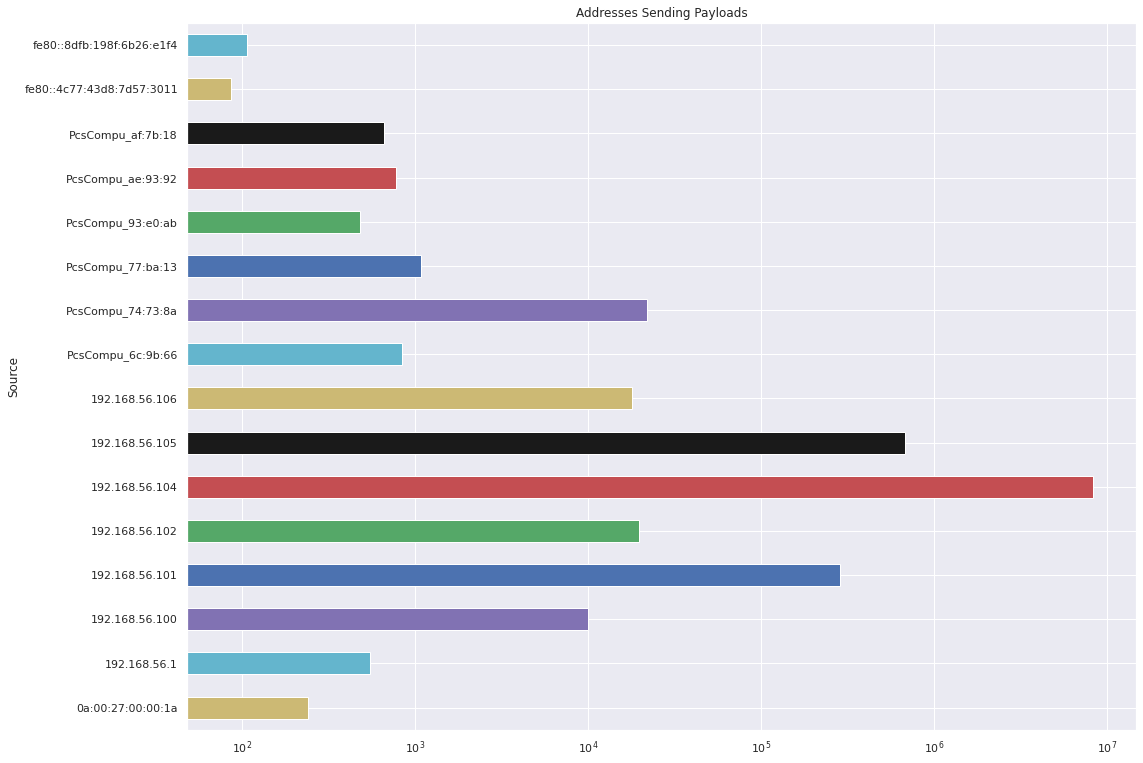

In [8]:
# Group by Source Address and Payload Length Sum
source_addresses = test_df.groupby('Source')['Length'].sum()
print("Total data transmitted by Source:\n"+str(source_addresses))

print(type(source_addresses))

source_addresses.plot.barh(title="Addresses Sending Payloads",figsize=(17,13), 
                           logx=True, color=["y","c","m", "b", "g", "r", "k"])

### Deep analysis of Destination Stats

In [9]:
# Unique Destination Addresses
print("\nUnique Destination Addresses")
dest_unique_df = test_df['Destination'].unique()
print(dest_unique_df)
print('\nUnique IPv4 Destination Addresses\n'+str(df_to_num(dest_unique_df)))


Unique Destination Addresses
['192.168.56.255' '192.168.56.102' '255.255.255.255' '192.168.56.1'
 'PcsCompu_af:7b:18' '0a:00:27:00:00:1a' 'PcsCompu_ae:93:92'
 '192.168.56.101' '192.168.56.100' 'PcsCompu_77:ba:13' '192.168.56.104'
 'PcsCompu_6c:9b:66' '192.168.56.106' 'PcsCompu_93:e0:ab' '192.168.56.105'
 'PcsCompu_74:73:8a' 'Broadcast' 'ff02::fb' '224.0.0.251'
 'ff02::1:ffe9:306c']

Unique IPv4 Destination Addresses
0     192.168.56.255
1     192.168.56.102
2    255.255.255.255
3       192.168.56.1
4     192.168.56.101
5     192.168.56.100
6     192.168.56.104
7     192.168.56.106
8     192.168.56.105
9        224.0.0.251
dtype: object


/home/devang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


Total data transmitted by Destination:
Destination
0a:00:27:00:00:1a        180
192.168.56.1             312
192.168.56.100          5814
192.168.56.101        235344
192.168.56.102         20574
192.168.56.104        470782
192.168.56.105       8018250
192.168.56.106        498950
192.168.56.255          1075
224.0.0.251               87
255.255.255.255          550
Broadcast              21336
PcsCompu_6c:9b:66        630
PcsCompu_74:73:8a       1200
PcsCompu_77:ba:13        966
PcsCompu_93:e0:ab        420
PcsCompu_ae:93:92        642
PcsCompu_af:7b:18        462
ff02::1:ffe9:306c         86
ff02::fb                 107
Name: Length, dtype: int64
<class 'pandas.core.series.Series'>


<AxesSubplot:title={'center':'Addresses Receiving Payloads'}, ylabel='Destination'>

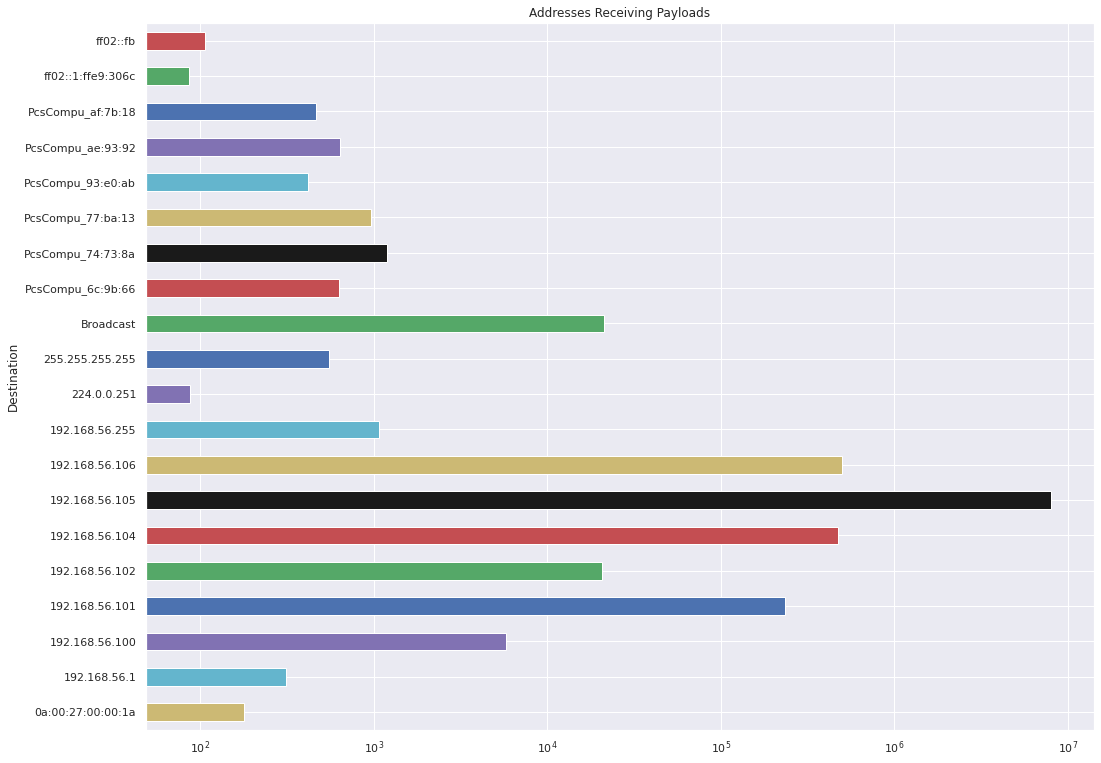

In [10]:
# Group by Source Address and Payload Length Sum
dest_addresses = test_df.groupby('Destination')['Length'].sum()
print("Total data transmitted by Destination:\n"+str(dest_addresses))

print(type(dest_addresses))

dest_addresses.plot.barh(title="Addresses Receiving Payloads",figsize=(17,13), 
                           logx=True, color=["y","c","m", "b", "g", "r", "k"])

### Deep analysis of Source port

Total data transmitted by Source Port (Top 20):
Source Port
80.0       8236467
22.0        220568
35613.0     215527
55297.0      99355
39141.0      90577
445.0        54363
46381.0      12759
60348.0      11889
67.0         10030
43381.0       8413
58310.0       6286
57670.0       6178
60885.0       6016
68.0          5814
58982.0       5528
34122.0       5258
34066.0       5126
58984.0       5119
33956.0       5076
34104.0       5006
Name: Length, dtype: int64


<AxesSubplot:title={'center':'Source Ports (Bytes Sent)'}, ylabel='Source Port'>

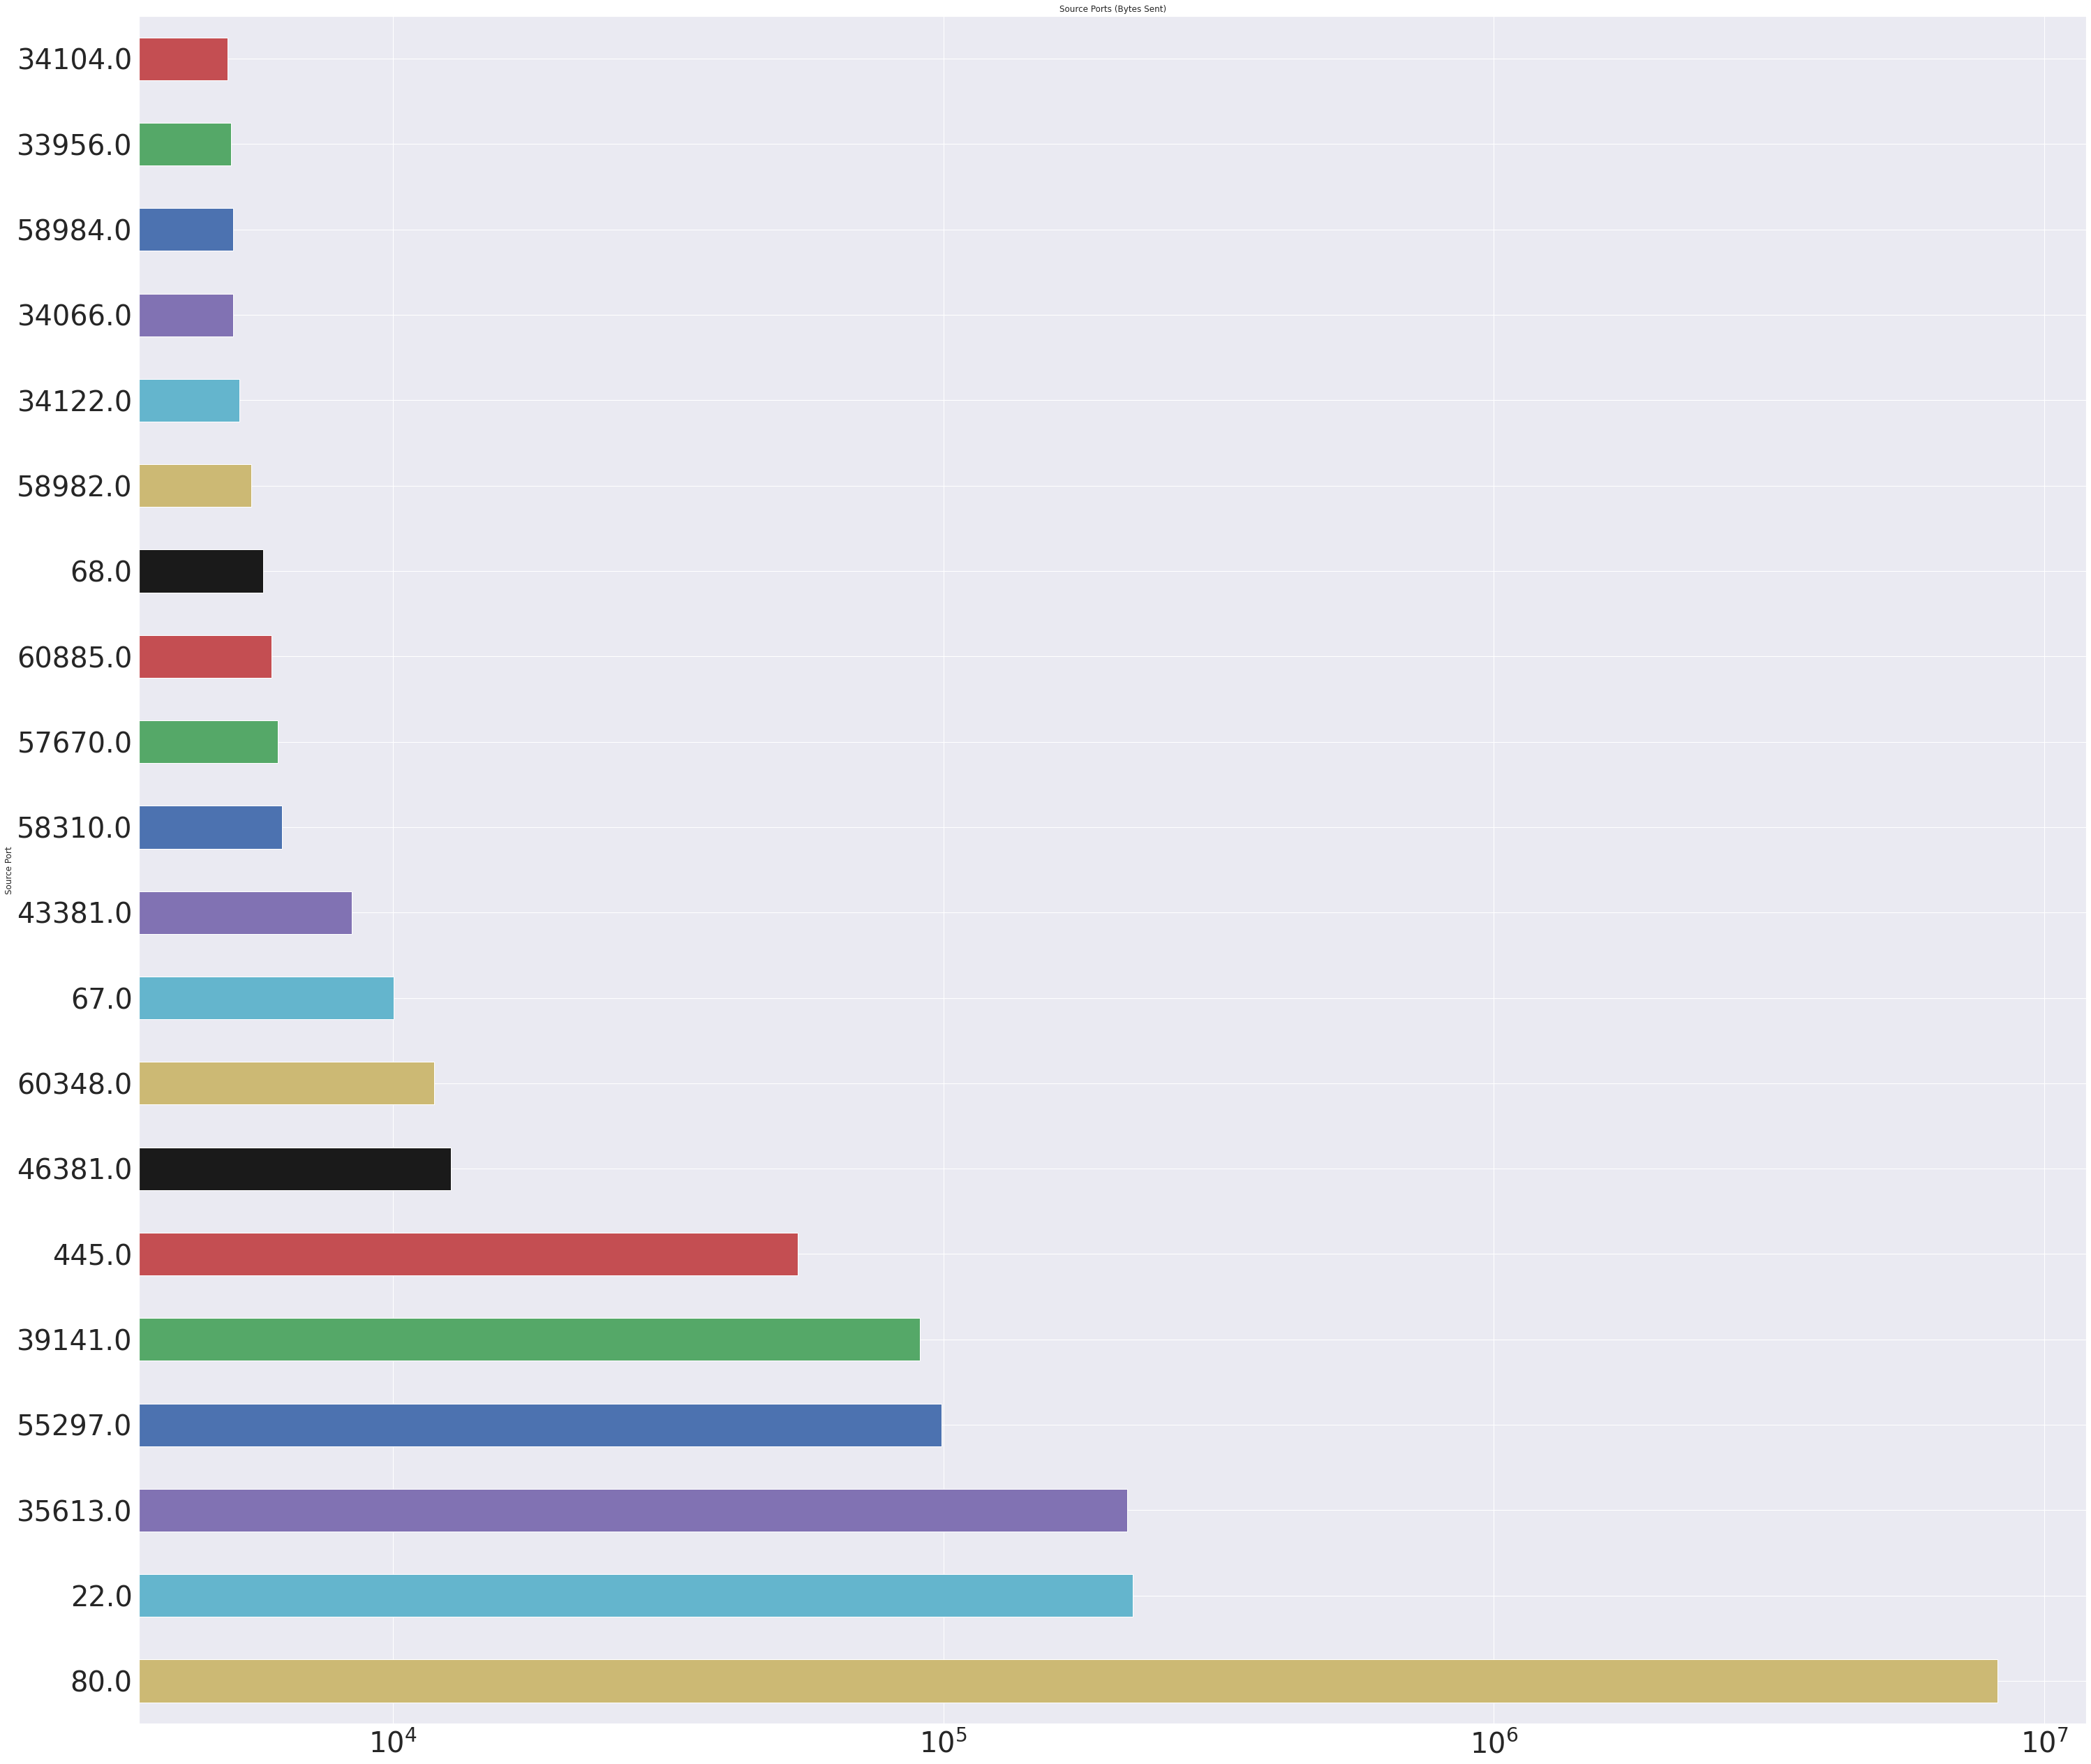

In [11]:
# Group by Source Port and Packet Length Sum
src_pkt_length_df = test_df[test_df['Source Port'] != int(0.0)]
src_pkt_length_df = src_pkt_length_df.groupby('Source Port')['Length'].sum().sort_values(ascending=False)
src_pkt_length_df = src_pkt_length_df.head(20)
print("Total data transmitted by Source Port (Top 20):\n"+str(src_pkt_length_df))
src_pkt_length_df.plot.barh(title="Source Ports (Bytes Sent)",figsize=(50,45), 
                           logx=True, color=["y","c","m", "b", "g", "r", "k"], fontsize=40)

Total data transmitted by Destination Port (Top 20):
Dest Port
35613.0    2106030
55297.0    1927590
46381.0    1401256
43381.0    1383305
39141.0     628678
80.0        459425
58982.0     426090
22.0        164167
58477.0     164078
445.0        63165
54093.0      61081
58976.0      28502
58980.0      27237
50693.0      15109
36821.0      14372
60348.0      11616
68.0         10030
58984.0       9418
45829.0       8395
36339.0       7349
Name: Length, dtype: int64


<AxesSubplot:title={'center':'Destination Ports (Bytes Sent)'}, ylabel='Dest Port'>

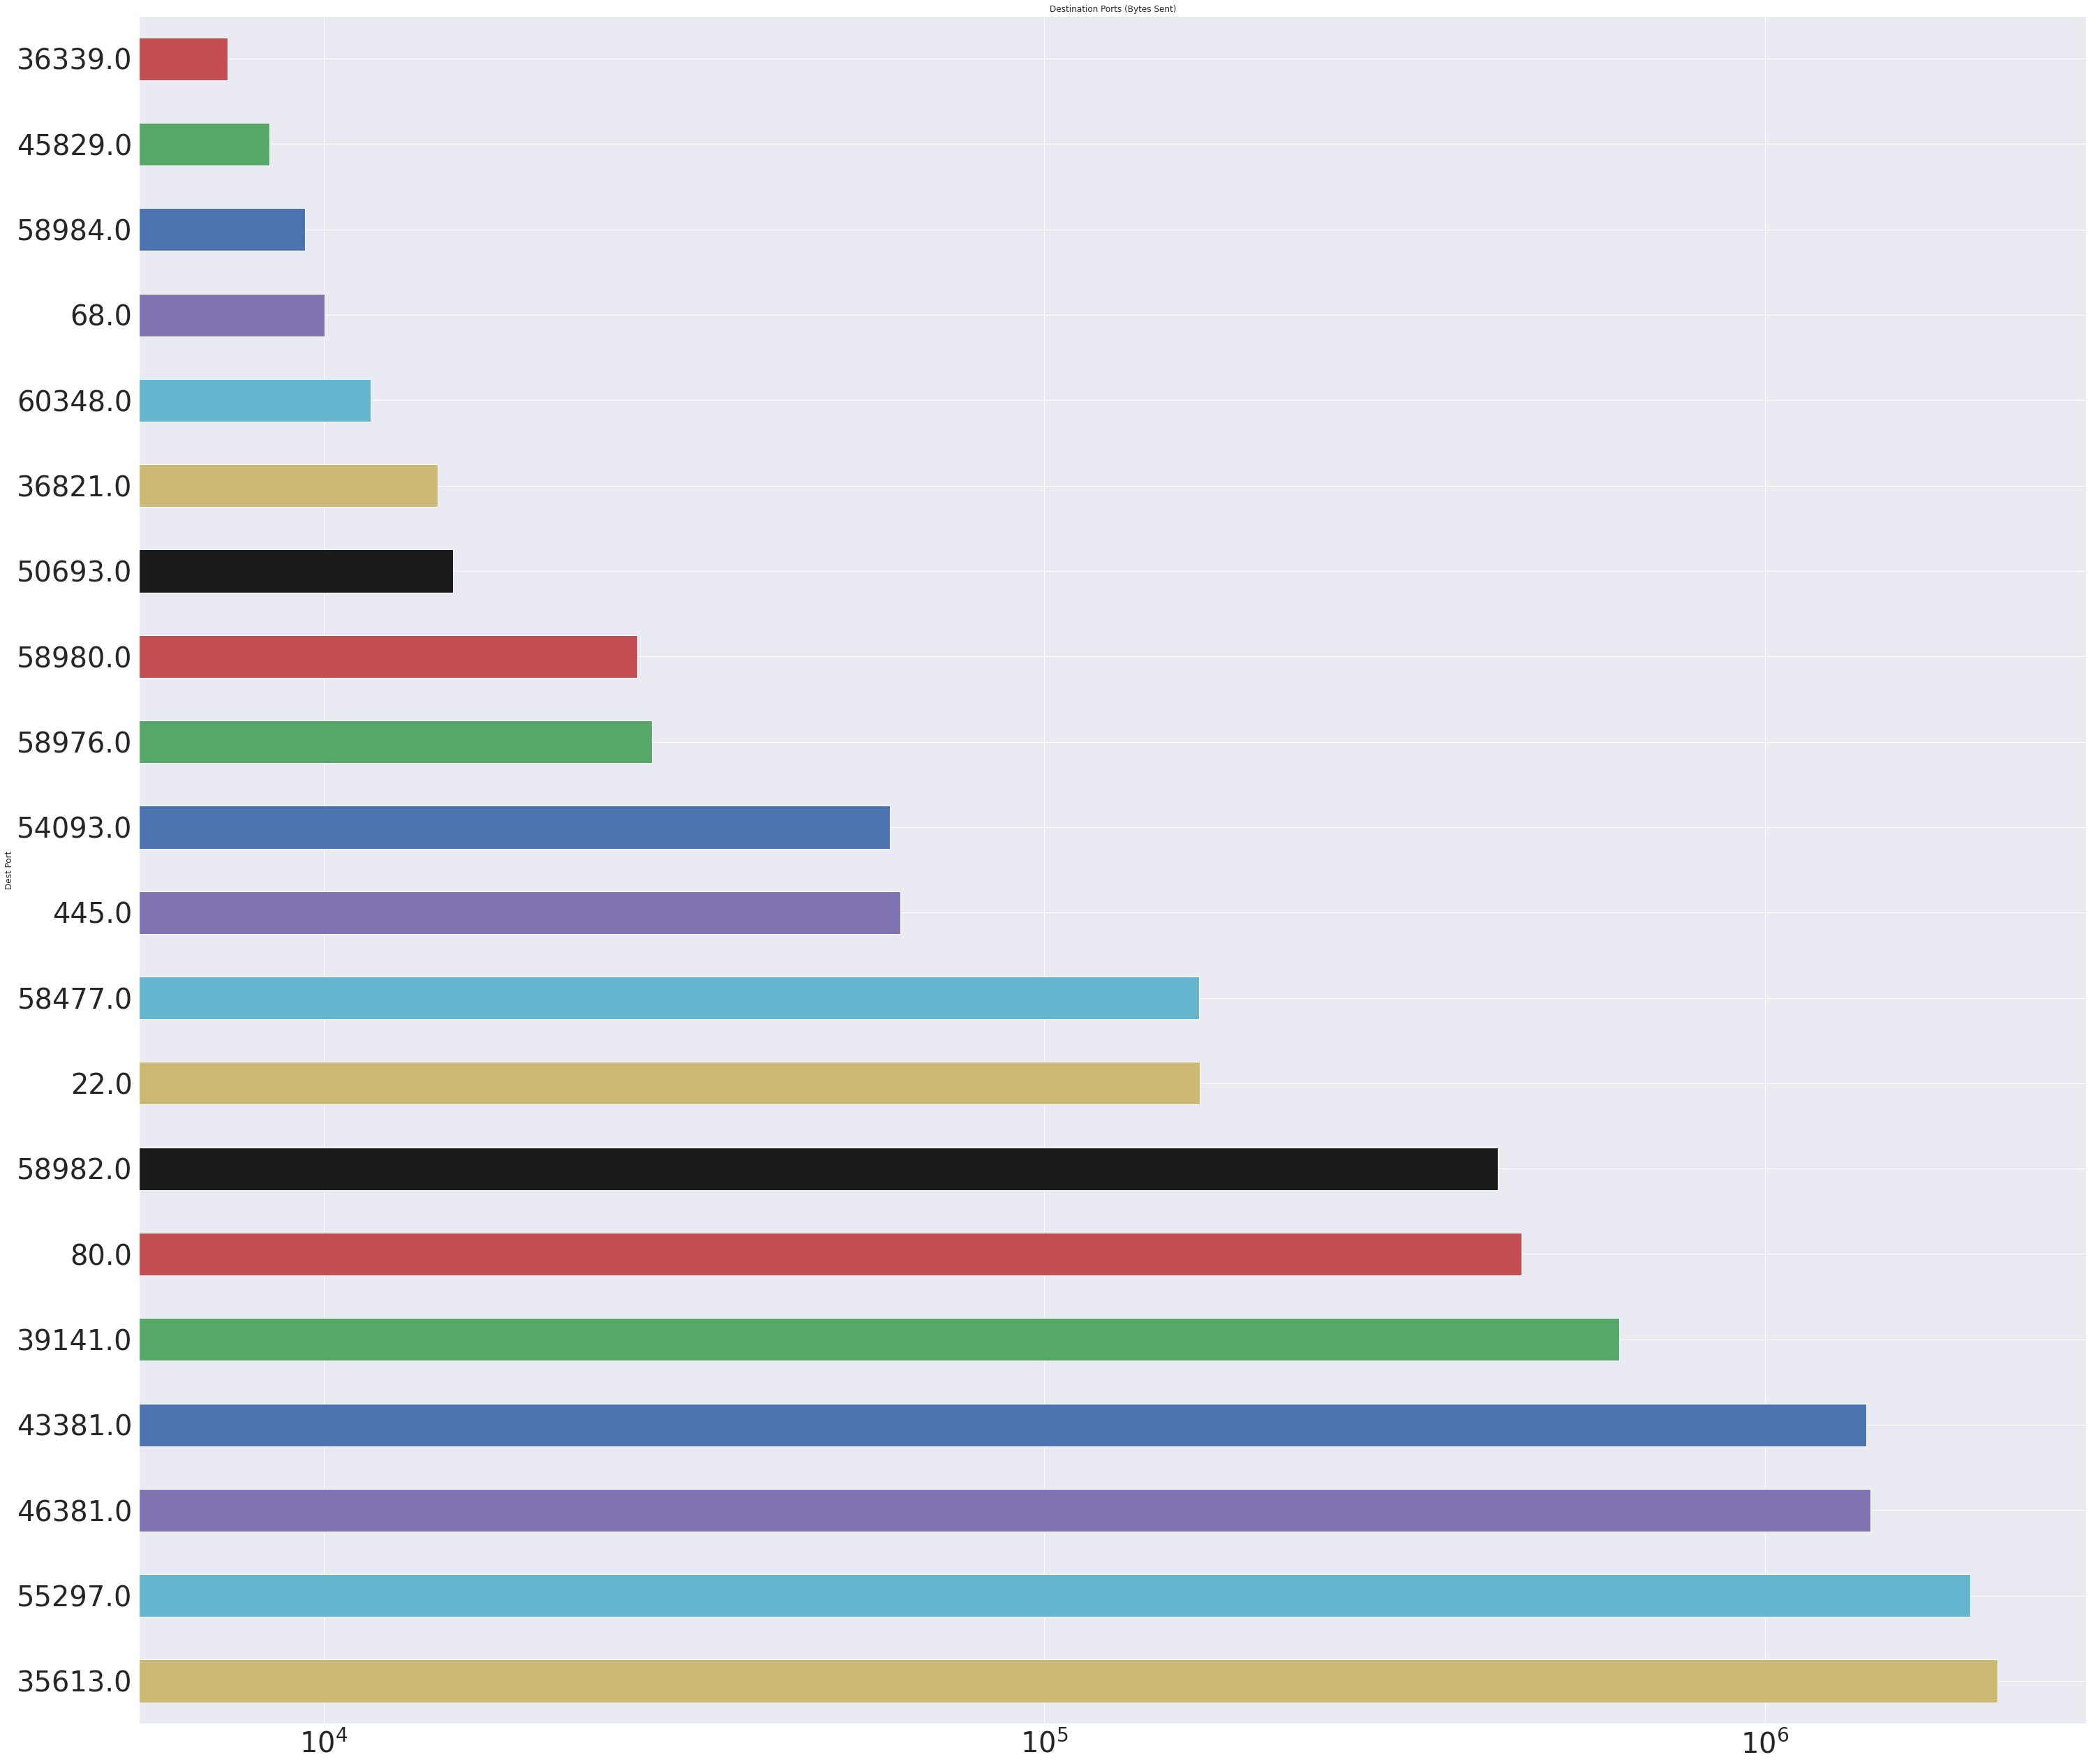

In [12]:
# Group by Destination Port and Packet Length Sum
dest_pkt_length_df = test_df[test_df['Dest Port'] != int(0.0)]
dest_pkt_length_df = dest_pkt_length_df.groupby('Dest Port')['Length'].sum().sort_values(ascending=False)
dest_pkt_length_df = dest_pkt_length_df.head(20)
print("Total data transmitted by Destination Port (Top 20):\n"+str(dest_pkt_length_df))
dest_pkt_length_df.plot.barh(title="Destination Ports (Bytes Sent)",figsize=(50,45), 
                           logx=True, color=["y","c","m", "b", "g", "r", "k"], fontsize=40)

              Source  Source Port     Destination  Dest Port  Length
1086  192.168.56.105      60885.0  192.168.56.104       23.0      58
1087  192.168.56.105      60885.0  192.168.56.104      143.0      58
1088  192.168.56.105      60885.0  192.168.56.104       25.0      58
1089  192.168.56.105      60885.0  192.168.56.104      199.0      58
1090  192.168.56.105      60885.0  192.168.56.104     1723.0      58
...              ...          ...             ...        ...     ...
1695  192.168.56.105      57670.0  192.168.56.101       13.0      58
1696  192.168.56.105      57670.0  192.168.56.101      427.0      58
1697  192.168.56.105      57670.0  192.168.56.101       26.0      58
1698  192.168.56.105      57670.0  192.168.56.101     2049.0      58
1699  192.168.56.105      57670.0  192.168.56.101       37.0      58

[300 rows x 5 columns]


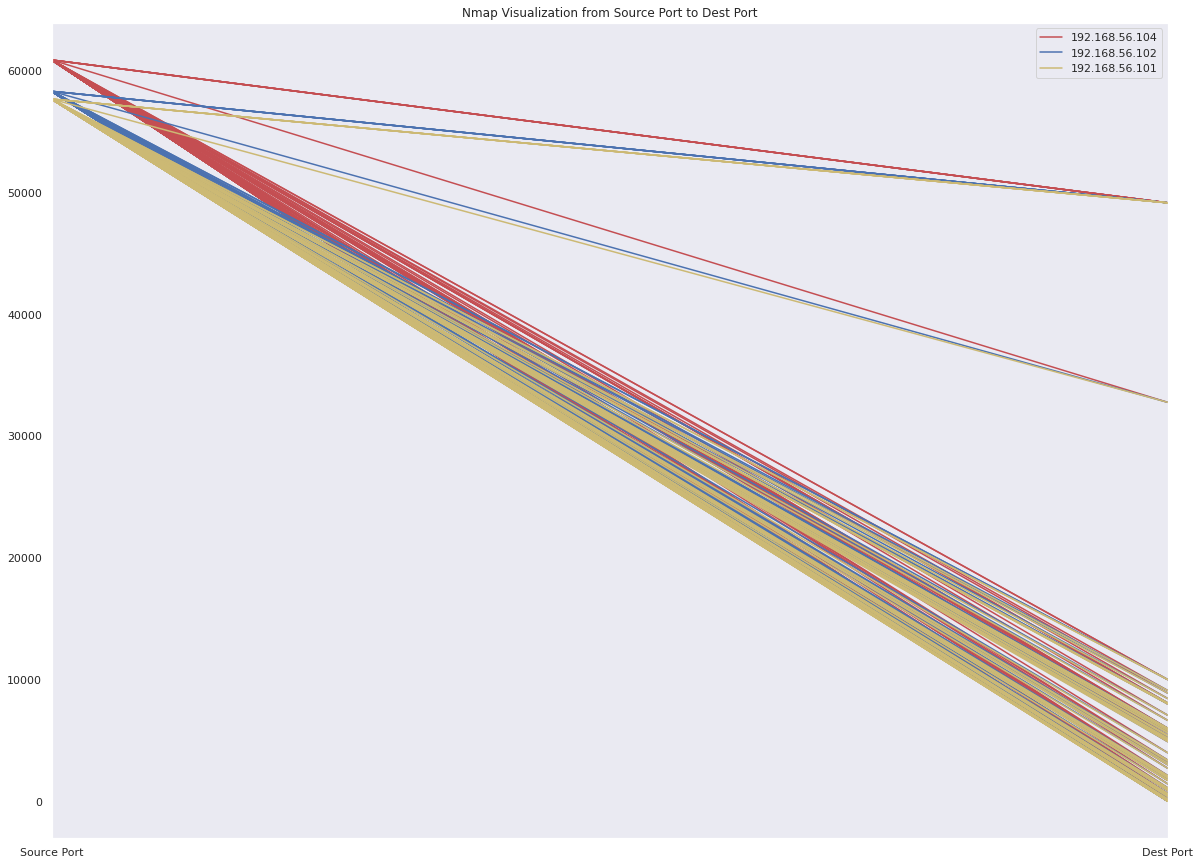

In [13]:
from pandas.plotting import parallel_coordinates
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

nmap_test = test_df[(test_df['Source'] == "192.168.56.105")\
                    & (test_df['Protocol'] == "TCP") & (test_df['Length'] == 58)]
print(nmap_test[['Source', 'Source Port', 'Destination', 'Dest Port', 'Length']])

figure(figsize=(20,15))
plotting.parallel_coordinates(nmap_test, "Destination", cols=['Source Port', 'Dest Port'], 
                              color=('r', 'b', 'y'))
plt.title('Nmap Visualization from Source Port to Dest Port')
plt.show()

#### Collective timeline analysis for all the machines in the network from 105

List of machines in the network receiving data from 192.168.56.105:
['192.168.56.100' '192.168.56.104' '192.168.56.102' '192.168.56.101']


              Time  Length
408   1.594609e+09     342
1086  1.594609e+09      58
1087  1.594609e+09      58
1088  1.594609e+09      58
1089  1.594609e+09      58
...            ...     ...
9172  1.594610e+09      66
9174  1.594610e+09      66
9176  1.594610e+09      66
9177  1.594610e+09      66
9179  1.594610e+09      66

[3884 rows x 2 columns]


Data received by all the machines in the N/W from 105 (every 60 seconds):
Time
(1594608878.116, 1594608938.116]         0
(1594608938.116, 1594608998.116]         0
(1594608998.116, 1594609058.116]       342
(1594609058.116, 1594609118.116]         0
(1594609118.116, 1594609178.116]         0
(1594609178.116, 1594609238.116]         0
(1594609238.116, 1594609298.116]     18480
(1594609298.116, 1594609358.116]      3544
(1594609358.116, 1594609418.116]      3256
(1594609418.116, 1594609478.116]     12863


<AxesSubplot:title={'center':'Data received by all the machines in the N/W from 105 (every 60 seconds)'}, ylabel='Time'>

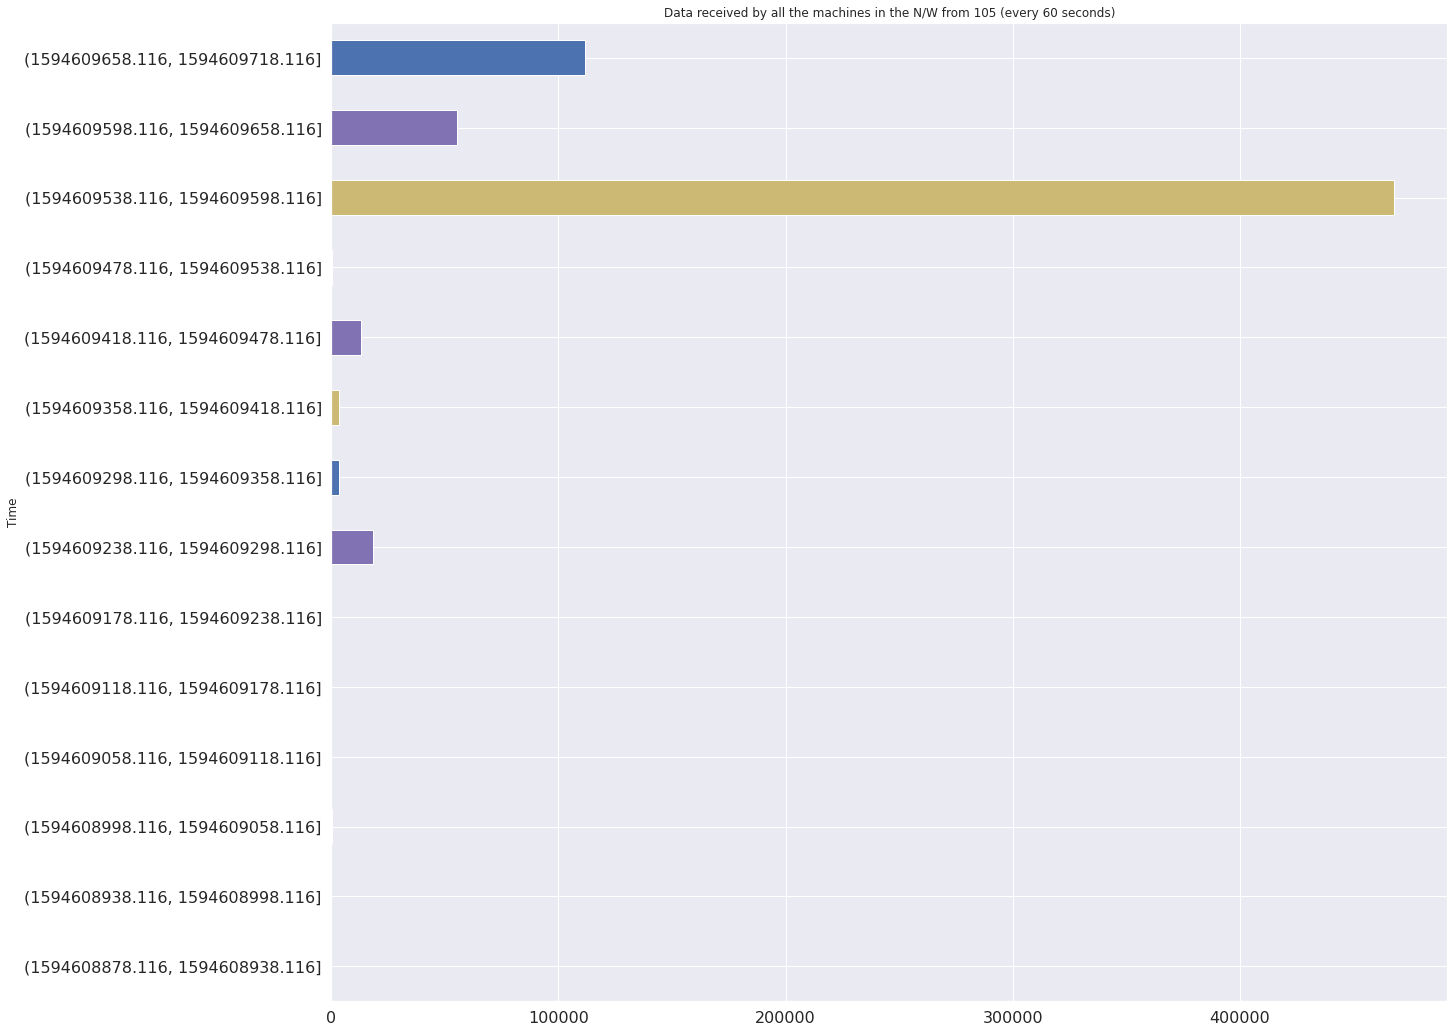

In [30]:
#groupby("time")['payload'].sum().plot(kind='barh',title="Destination Ports (Bytes Received)",figsize=(8,5))

time_slice_df = test_df[(test_df['Source'] == "192.168.56.105")]
print("List of machines in the network receiving data from 192.168.56.105:")
print(time_slice_df["Destination"].unique())

print("\n")
time_slice_df = time_slice_df[["Time", "Length"]]
print(time_slice_df)

start_time = float(1594608878.115614448)
end_time = float(1594609735.745534519)

bins = np.arange(start_time, end_time+1, 60)
time_slice_df = time_slice_df.groupby(pd.cut(time_slice_df['Time'], bins=bins)).Length.sum()
print("\n")
print("Data received by all the machines in the N/W from 105 (every 60 seconds):\n"+str(time_slice_df))
time_slice_df.plot.barh(title="Data received by all the machines in the N/W from 105 (every 60 seconds)",
                        figsize=(20,18), color=["m", "b", "y"], fontsize=16)

#### Timeline analysis for 192.168.56.101

              Time  Length
1509  1.594609e+09      58
1510  1.594609e+09      58
1511  1.594609e+09      58
1512  1.594609e+09      58
1513  1.594609e+09      58
...            ...     ...
9172  1.594610e+09      66
9174  1.594610e+09      66
9176  1.594610e+09      66
9177  1.594610e+09      66
9179  1.594610e+09      66

[1464 rows x 2 columns]
Data received by 192.168.56.101 every 30 seconds:
Time
(1594608878.116, 1594608938.116]         0
(1594608938.116, 1594608998.116]         0
(1594608998.116, 1594609058.116]         0
(1594609058.116, 1594609118.116]         0
(1594609118.116, 1594609178.116]         0
(1594609178.116, 1594609238.116]         0
(1594609238.116, 1594609298.116]      6178
(1594609298.116, 1594609358.116]         0
(1594609358.116, 1594609418.116]         0
(1594609418.116, 1594609478.116]         0
(1594609478.116, 1594609538.116]         0
(1594609538.116, 1594609598.116]     44828
(1594609598.116, 1594609658.116]     55030
(1594609658.116, 1594609718.116]    1

<AxesSubplot:title={'center':'Data received by 192.168.56.101 every 30 seconds'}, ylabel='Time'>

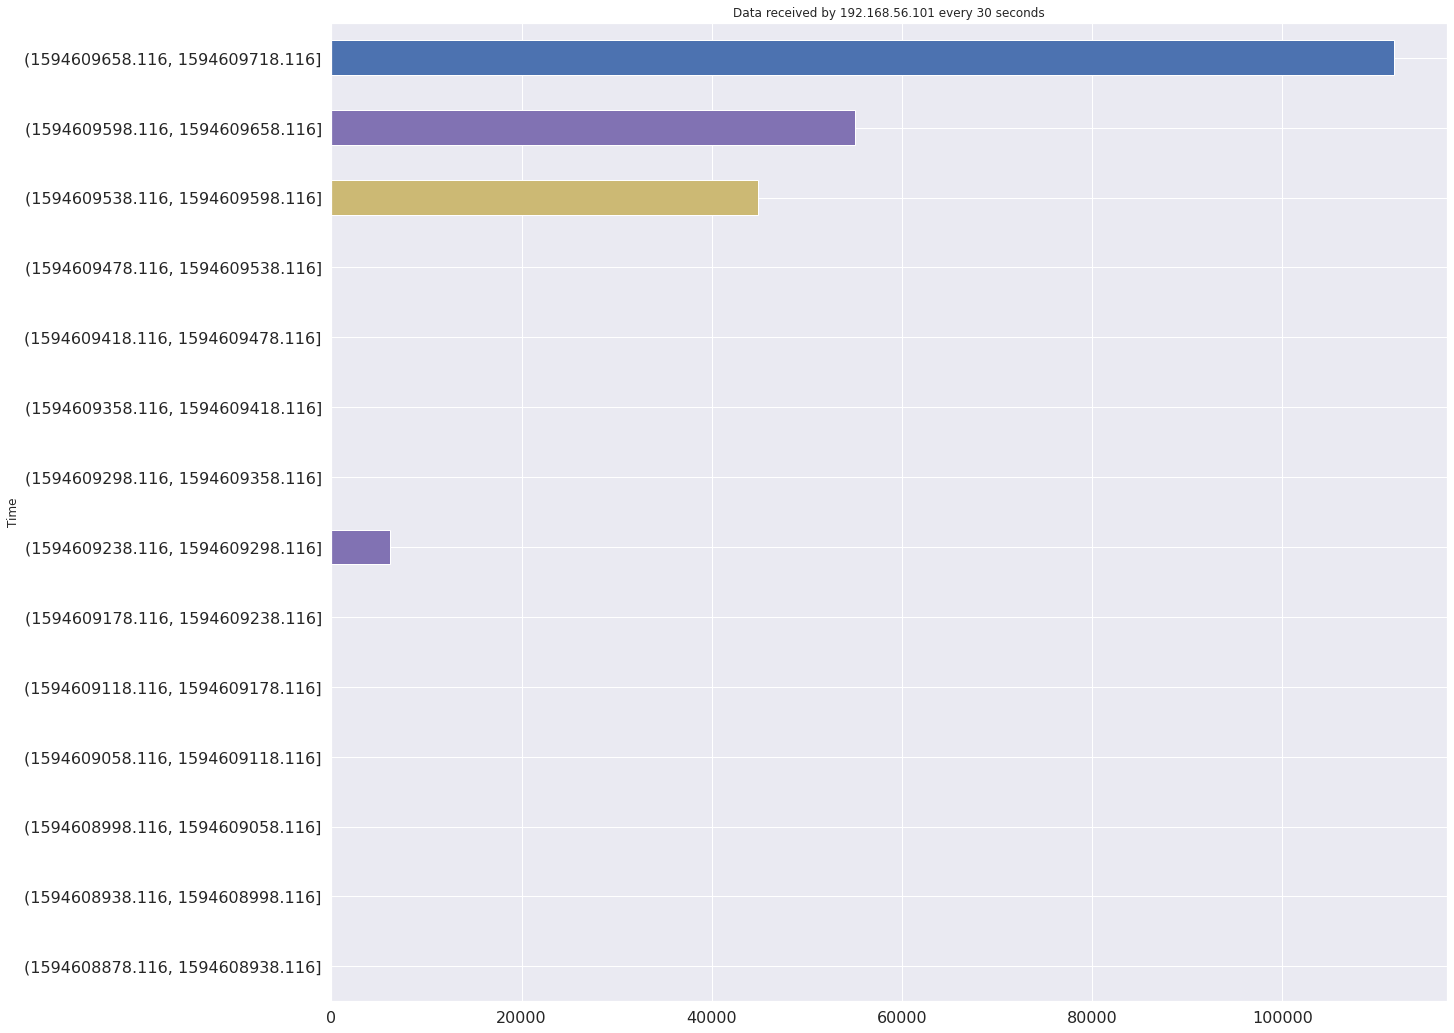

In [15]:
#groupby("time")['payload'].sum().plot(kind='barh',title="Destination Ports (Bytes Received)",figsize=(8,5))

time_slice_df = test_df[(test_df['Source'] == "192.168.56.105") & (test_df['Destination'] == "192.168.56.101")]
time_slice_df = time_slice_df[["Time", "Length"]]
print(time_slice_df)

start_time = float(1594608878.115614448)
end_time = float(1594609735.745534519)

bins = np.arange(start_time, end_time+1, 60)
time_slice_df = time_slice_df.groupby(pd.cut(time_slice_df['Time'], bins=bins)).Length.sum()
print("Data received by 192.168.56.101 every 30 seconds:\n"+str(time_slice_df))
time_slice_df.plot.barh(title="Data received by 192.168.56.101 every 30 seconds",
                        figsize=(20,18), color=["m", "b", "y"], fontsize=16)

#### Timeline analysis for 192.168.56.102

              Time  Length
1296  1.594609e+09      58
1297  1.594609e+09      58
1298  1.594609e+09      58
1299  1.594609e+09      58
1300  1.594609e+09      58
...            ...     ...
1484  1.594609e+09      58
1488  1.594609e+09      58
1492  1.594609e+09      58
1494  1.594609e+09      58
1495  1.594609e+09      58

[109 rows x 2 columns]
Data received by 192.168.56.101 every 30 seconds:
Time
(1594608878.116, 1594608938.116]       0
(1594608938.116, 1594608998.116]       0
(1594608998.116, 1594609058.116]       0
(1594609058.116, 1594609118.116]       0
(1594609118.116, 1594609178.116]       0
(1594609178.116, 1594609238.116]       0
(1594609238.116, 1594609298.116]    6286
(1594609298.116, 1594609358.116]       0
(1594609358.116, 1594609418.116]       0
(1594609418.116, 1594609478.116]       0
(1594609478.116, 1594609538.116]       0
(1594609538.116, 1594609598.116]       0
(1594609598.116, 1594609658.116]       0
(1594609658.116, 1594609718.116]       0
Name: Length, dtype: in

<AxesSubplot:title={'center':'Data received by 192.168.56.102 every 30 seconds'}, ylabel='Time'>

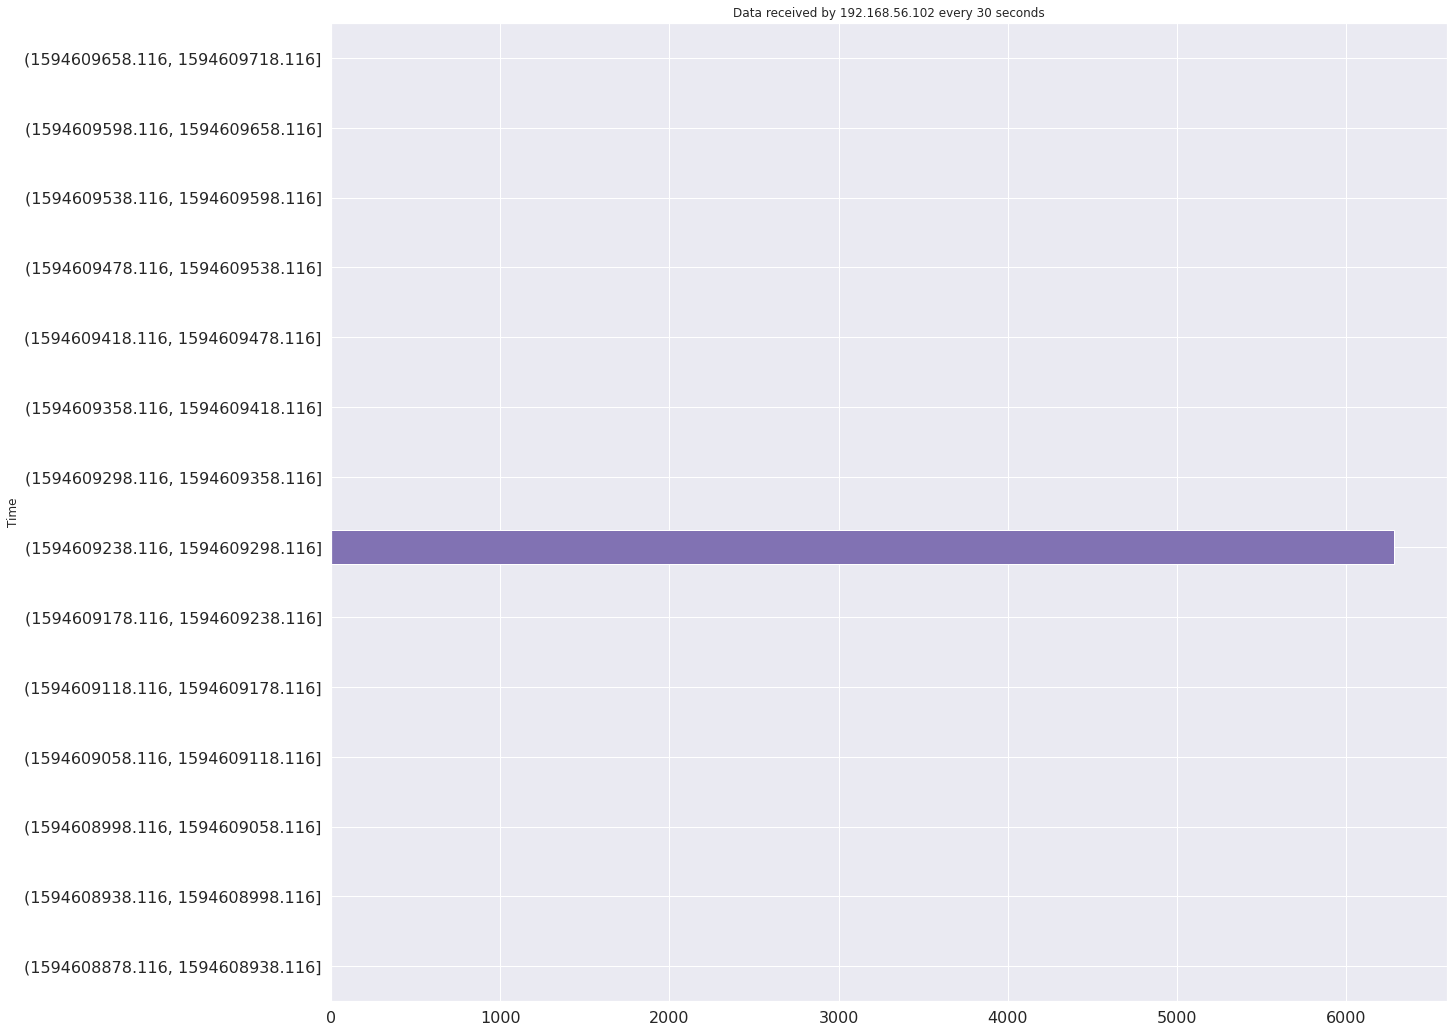

In [16]:
#groupby("time")['payload'].sum().plot(kind='barh',title="Destination Ports (Bytes Received)",figsize=(8,5))

time_slice_df = test_df[(test_df['Source'] == "192.168.56.105") & (test_df['Destination'] == "192.168.56.102")]
time_slice_df = time_slice_df[["Time", "Length"]]
print(time_slice_df)

start_time = float(1594608878.115614448)
end_time = float(1594609735.745534519)

bins = np.arange(start_time, end_time+1, 60)
time_slice_df = time_slice_df.groupby(pd.cut(time_slice_df['Time'], bins=bins)).Length.sum()
print("Data received by 192.168.56.101 every 30 seconds:\n"+str(time_slice_df))
time_slice_df.plot.barh(title="Data received by 192.168.56.102 every 30 seconds",
                        figsize=(20,18), color=["m", "b", "y"], fontsize=16)

#### Timeline analysis for 192.168.56.104

              Time  Length
1086  1.594609e+09      58
1087  1.594609e+09      58
1088  1.594609e+09      58
1089  1.594609e+09      58
1090  1.594609e+09      58
...            ...     ...
6192  1.594610e+09      66
6841  1.594610e+09      66
6845  1.594610e+09      66
7078  1.594610e+09      66
7080  1.594610e+09      66

[2308 rows x 2 columns]
Data received by 192.168.56.101 every 30 seconds:
Time
(1594608878.116, 1594608938.116]         0
(1594608938.116, 1594608998.116]         0
(1594608998.116, 1594609058.116]         0
(1594609058.116, 1594609118.116]         0
(1594609118.116, 1594609178.116]         0
(1594609178.116, 1594609238.116]         0
(1594609238.116, 1594609298.116]      6016
(1594609298.116, 1594609358.116]      3202
(1594609358.116, 1594609418.116]      3256
(1594609418.116, 1594609478.116]     12863
(1594609478.116, 1594609538.116]       132
(1594609538.116, 1594609598.116]    422725
(1594609598.116, 1594609658.116]       264
(1594609658.116, 1594609718.116]     

<AxesSubplot:title={'center':'Data received by 192.168.56.104 every 30 seconds'}, ylabel='Time'>

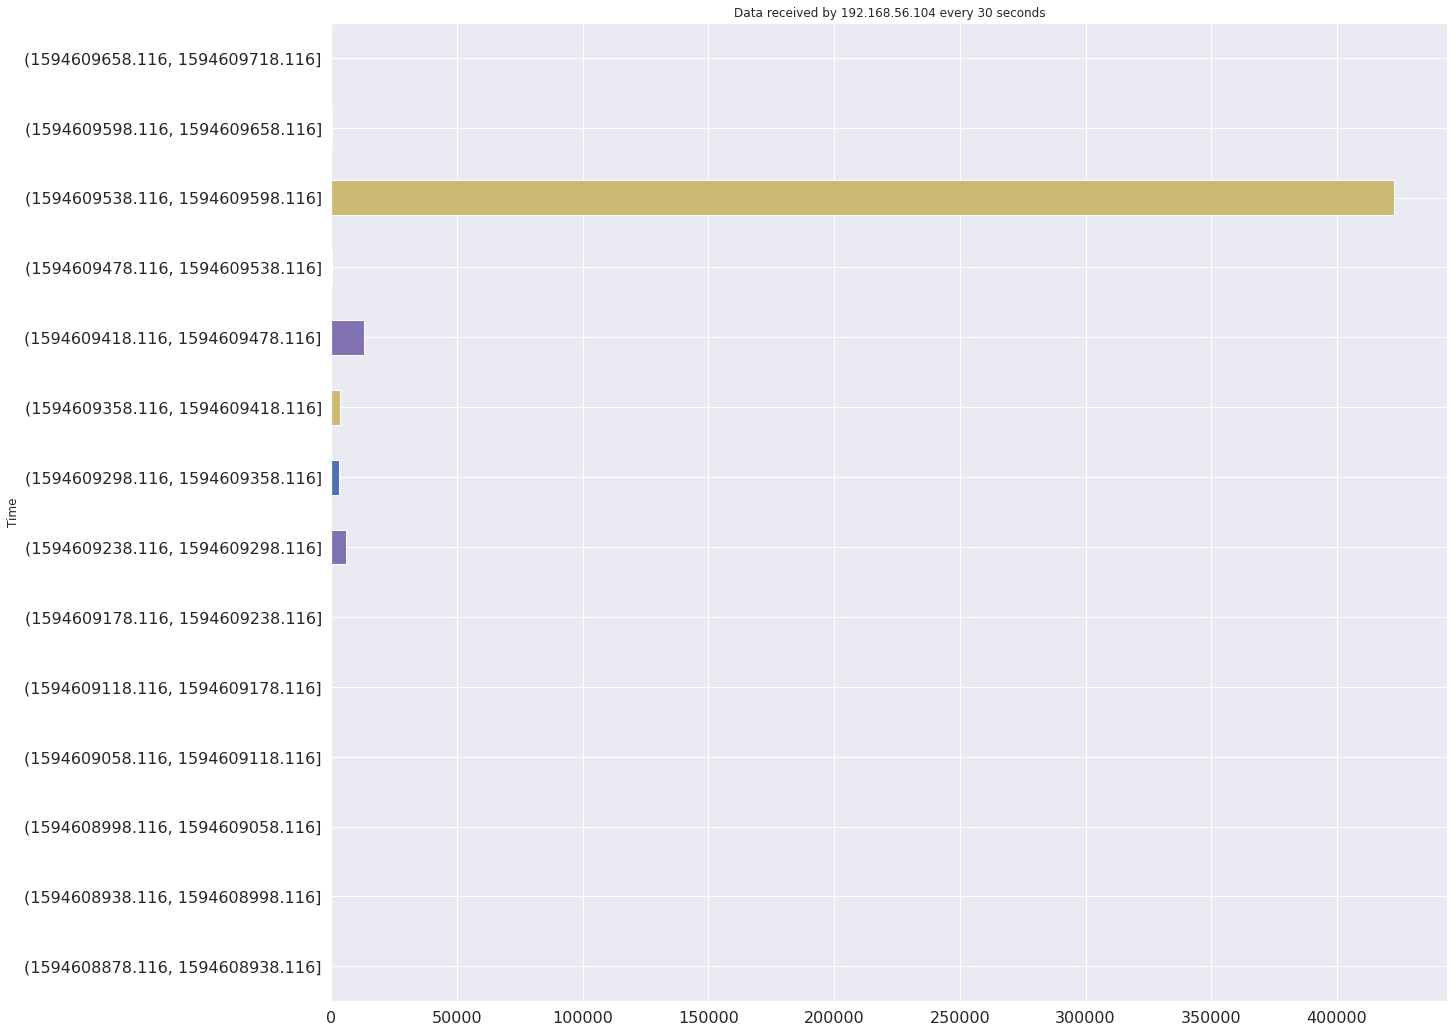

In [17]:
#groupby("time")['payload'].sum().plot(kind='barh',title="Destination Ports (Bytes Received)",figsize=(8,5))

time_slice_df = test_df[(test_df['Source'] == "192.168.56.105") & (test_df['Destination'] == "192.168.56.104")]
time_slice_df = time_slice_df[["Time", "Length"]]
print(time_slice_df)

start_time = float(1594608878.115614448)
end_time = float(1594609735.745534519)

bins = np.arange(start_time, end_time+1, 60)
time_slice_df = time_slice_df.groupby(pd.cut(time_slice_df['Time'], bins=bins)).Length.sum()
print("Data received by 192.168.56.101 every 30 seconds:\n"+str(time_slice_df))
time_slice_df.plot.barh(title="Data received by 192.168.56.104 every 30 seconds",
                        figsize=(20,18), color=["m", "b", "y"], fontsize=16)

#### OWASP ZAP fuzzer 104

              Time  Length
1111  1.594609e+09      58
1122  1.594609e+09      54
1720  1.594609e+09      74
1722  1.594609e+09      66
1723  1.594609e+09     348
...            ...     ...
6192  1.594610e+09      66
6841  1.594610e+09      66
6845  1.594610e+09      66
7078  1.594610e+09      66
7080  1.594610e+09      66

[2206 rows x 2 columns]
Data received by 192.168.56.104 every 30 seconds (on port 80):
Time
(1594608878.116, 1594608908.116]         0
(1594608908.116, 1594608938.116]         0
(1594608938.116, 1594608968.116]         0
(1594608968.116, 1594608998.116]         0
(1594608998.116, 1594609028.116]         0
(1594609028.116, 1594609058.116]         0
(1594609058.116, 1594609088.116]         0
(1594609088.116, 1594609118.116]         0
(1594609118.116, 1594609148.116]         0
(1594609148.116, 1594609178.116]         0
(1594609178.116, 1594609208.116]         0
(1594609208.116, 1594609238.116]         0
(1594609238.116, 1594609268.116]       112
(1594609268.116, 1594609

<AxesSubplot:title={'center':'Data received by 192.168.56.104 every 30 seconds'}, ylabel='Time'>

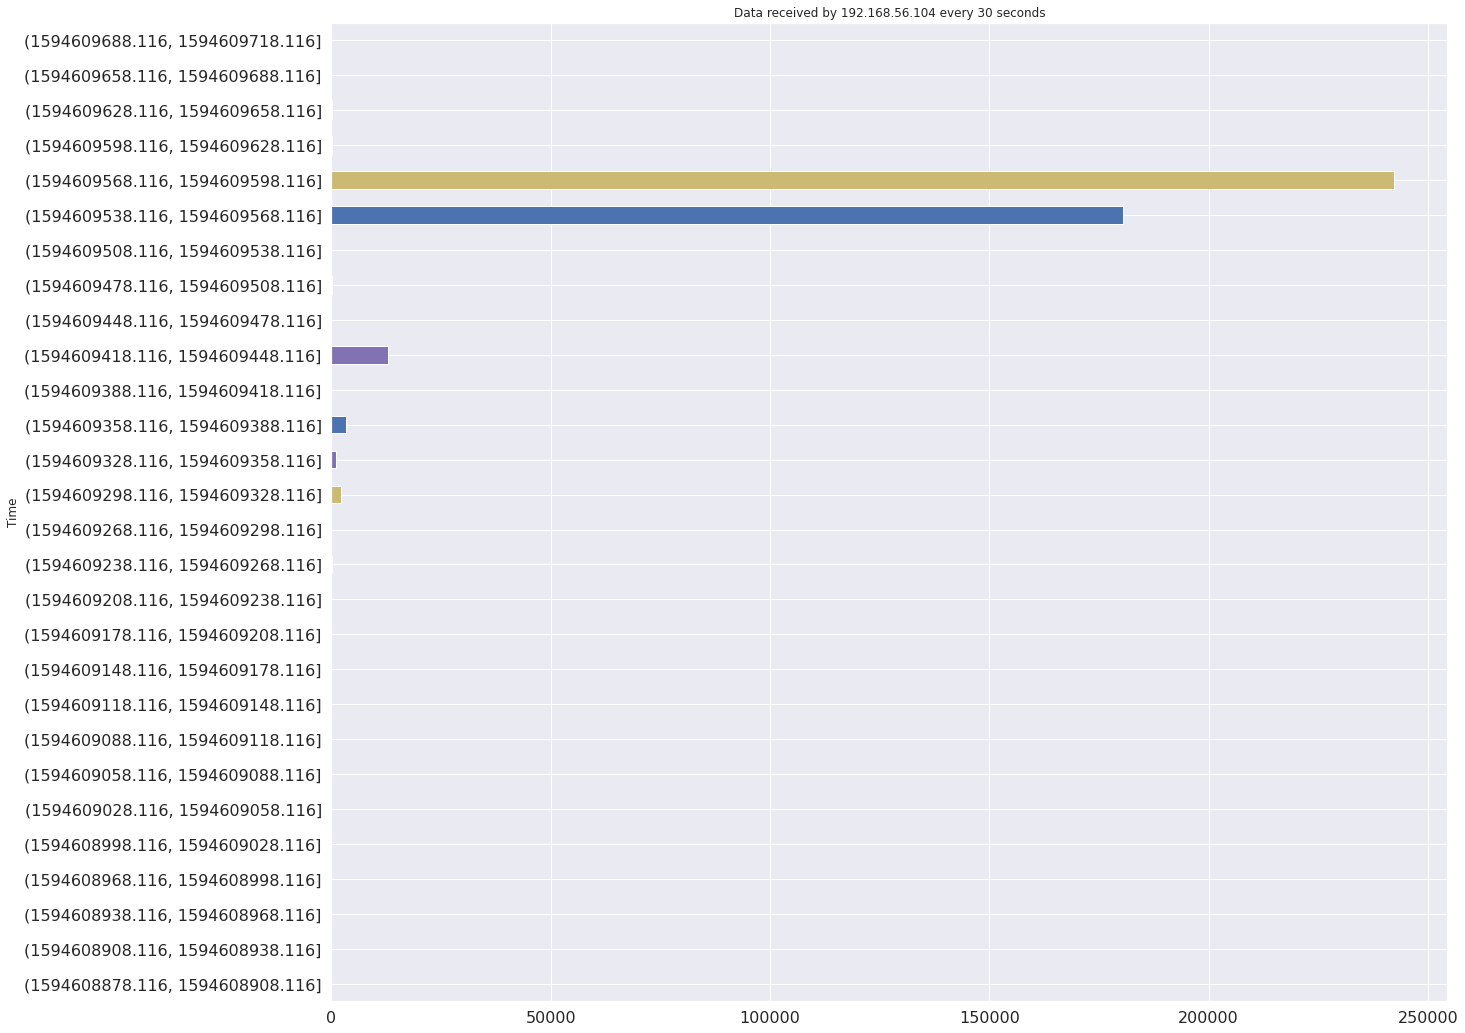

In [18]:
#groupby("time")['payload'].sum().plot(kind='barh',title="Destination Ports (Bytes Received)",figsize=(8,5))

time_slice_df = test_df[(test_df['Source'] == "192.168.56.105") &
                        (test_df['Destination'] == "192.168.56.104") & (test_df['Dest Port'] == 80)]
time_slice_df = time_slice_df[["Time", "Length"]]
print(time_slice_df)
start_time = float(1594608878.115614448)
end_time = float(1594609735.745534519)

bins = np.arange(start_time, end_time+1, 30)
time_slice_df = time_slice_df.groupby(pd.cut(time_slice_df['Time'], bins=bins)).Length.sum()
print("Data received by 192.168.56.104 every 30 seconds (on port 80):\n"+str(time_slice_df))
time_slice_df.plot.barh(title="Data received by 192.168.56.104 every 30 seconds",
                        figsize=(20,18), color=["m", "b", "y"], fontsize=16)

#### enum4linux at 101 (port 139 and 445)

              Time  Length
224   1.594609e+09      74
226   1.594609e+09      66
227   1.594609e+09     260
230   1.594609e+09      66
231   1.594609e+09     226
...            ...     ...
6831  1.594610e+09     234
6833  1.594610e+09     158
6835  1.594610e+09     138
6837  1.594610e+09      66
6839  1.594610e+09      66

[433 rows x 2 columns]
Data received by 192.168.56.101 every 30 seconds (on SMB ports 139 and 445):
Time
(1594608878.116, 1594608908.116]        0
(1594608908.116, 1594608938.116]        0
(1594608938.116, 1594608968.116]     2982
(1594608968.116, 1594608998.116]      303
(1594608998.116, 1594609028.116]        0
(1594609028.116, 1594609058.116]        0
(1594609058.116, 1594609088.116]        0
(1594609088.116, 1594609118.116]        0
(1594609118.116, 1594609148.116]        0
(1594609148.116, 1594609178.116]        0
(1594609178.116, 1594609208.116]        0
(1594609208.116, 1594609238.116]        0
(1594609238.116, 1594609268.116]       58
(1594609268.116, 1594609

<AxesSubplot:title={'center':'Data received by 192.168.56.101 every 30 seconds'}, ylabel='Time'>

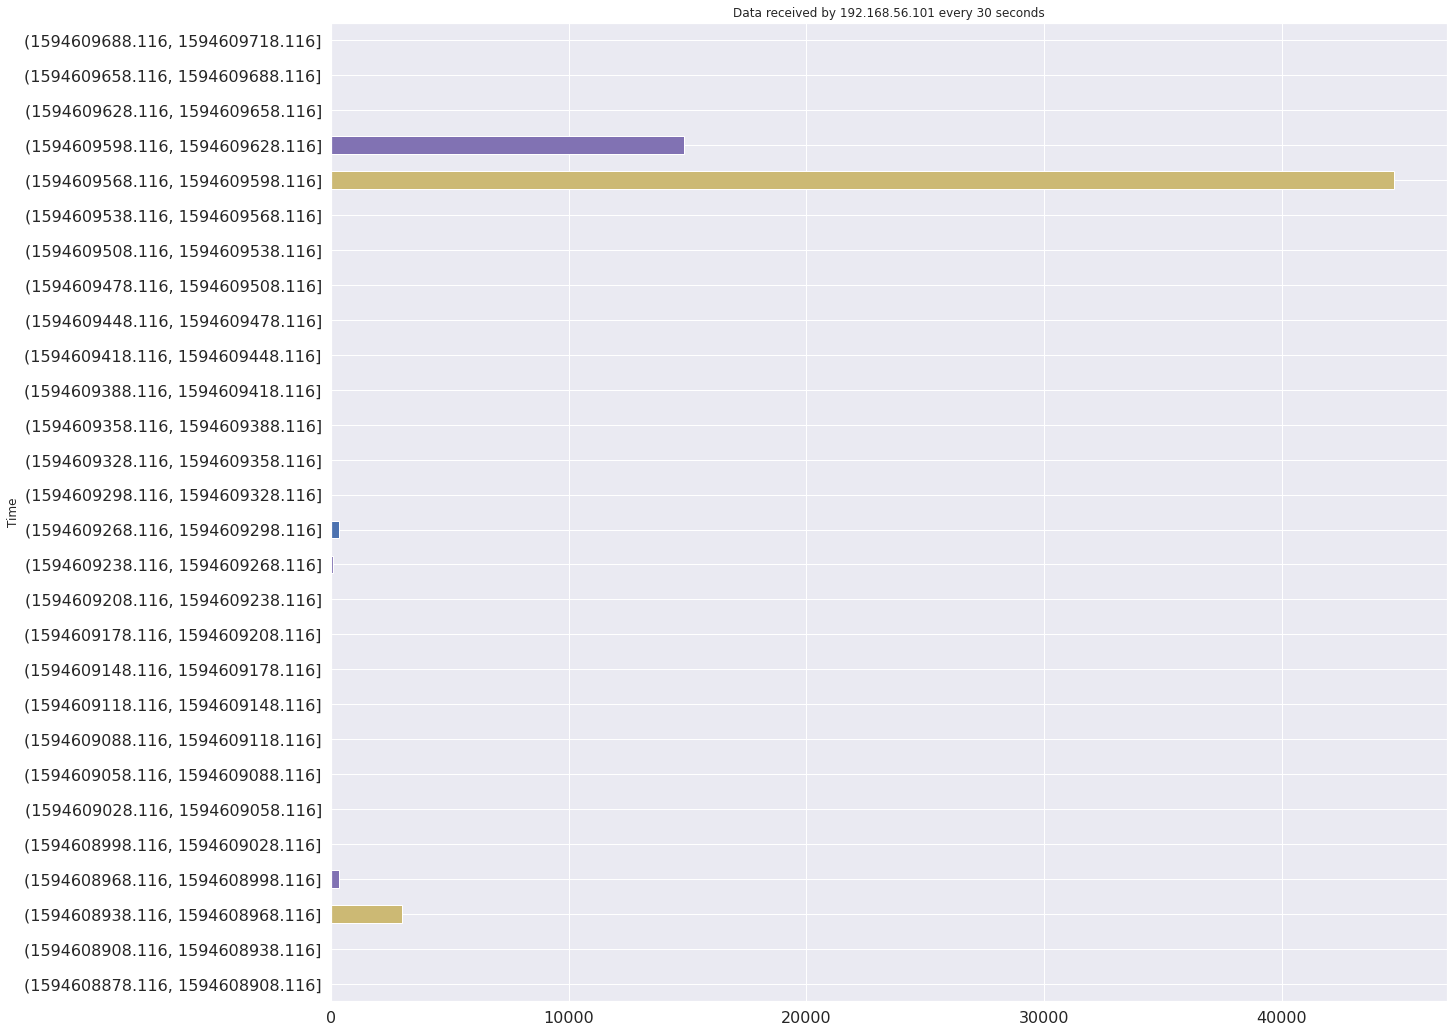

In [19]:
#groupby("time")['payload'].sum().plot(kind='barh',title="Destination Ports (Bytes Received)",figsize=(8,5))

time_slice_df = test_df[(test_df['Source'] == "192.168.56.105")
                        & (test_df['Destination'] == "192.168.56.101") & 
                        (test_df['Dest Port'] == 139) | (test_df['Dest Port'] == 445)]
time_slice_df = time_slice_df[["Time", "Length"]]
print(time_slice_df)

start_time = float(1594608878.115614448)
end_time = float(1594609735.745534519)

bins = np.arange(start_time, end_time+1, 30)
time_slice_df = time_slice_df.groupby(pd.cut(time_slice_df['Time'], bins=bins)).Length.sum()
print("Data received by 192.168.56.101 every 30 seconds (on SMB ports 139 and 445):\n"+str(time_slice_df))
time_slice_df.plot.barh(title="Data received by 192.168.56.101 every 30 seconds",
                        figsize=(20,18), color=["m", "b", "y"], fontsize=16)

#### Patator SSH password crack on 101

              Time  Length
1536  1.594609e+09      58
1549  1.594609e+09      54
6850  1.594610e+09      74
6852  1.594610e+09      66
6854  1.594610e+09      66
...            ...     ...
9172  1.594610e+09      66
9174  1.594610e+09      66
9176  1.594610e+09      66
9177  1.594610e+09      66
9179  1.594610e+09      66

[957 rows x 2 columns]
Data received by 192.168.56.101 every 30 seconds (on SSH port 22):
Time
(1594608878.116, 1594608908.116]        0
(1594608908.116, 1594608938.116]        0
(1594608938.116, 1594608968.116]        0
(1594608968.116, 1594608998.116]        0
(1594608998.116, 1594609028.116]        0
(1594609028.116, 1594609058.116]        0
(1594609058.116, 1594609088.116]        0
(1594609088.116, 1594609118.116]        0
(1594609118.116, 1594609148.116]        0
(1594609148.116, 1594609178.116]        0
(1594609178.116, 1594609208.116]        0
(1594609208.116, 1594609238.116]        0
(1594609238.116, 1594609268.116]        0
(1594609268.116, 1594609298.116]  

<AxesSubplot:title={'center':'Data received by 192.168.56.101 every 30 seconds'}, ylabel='Time'>

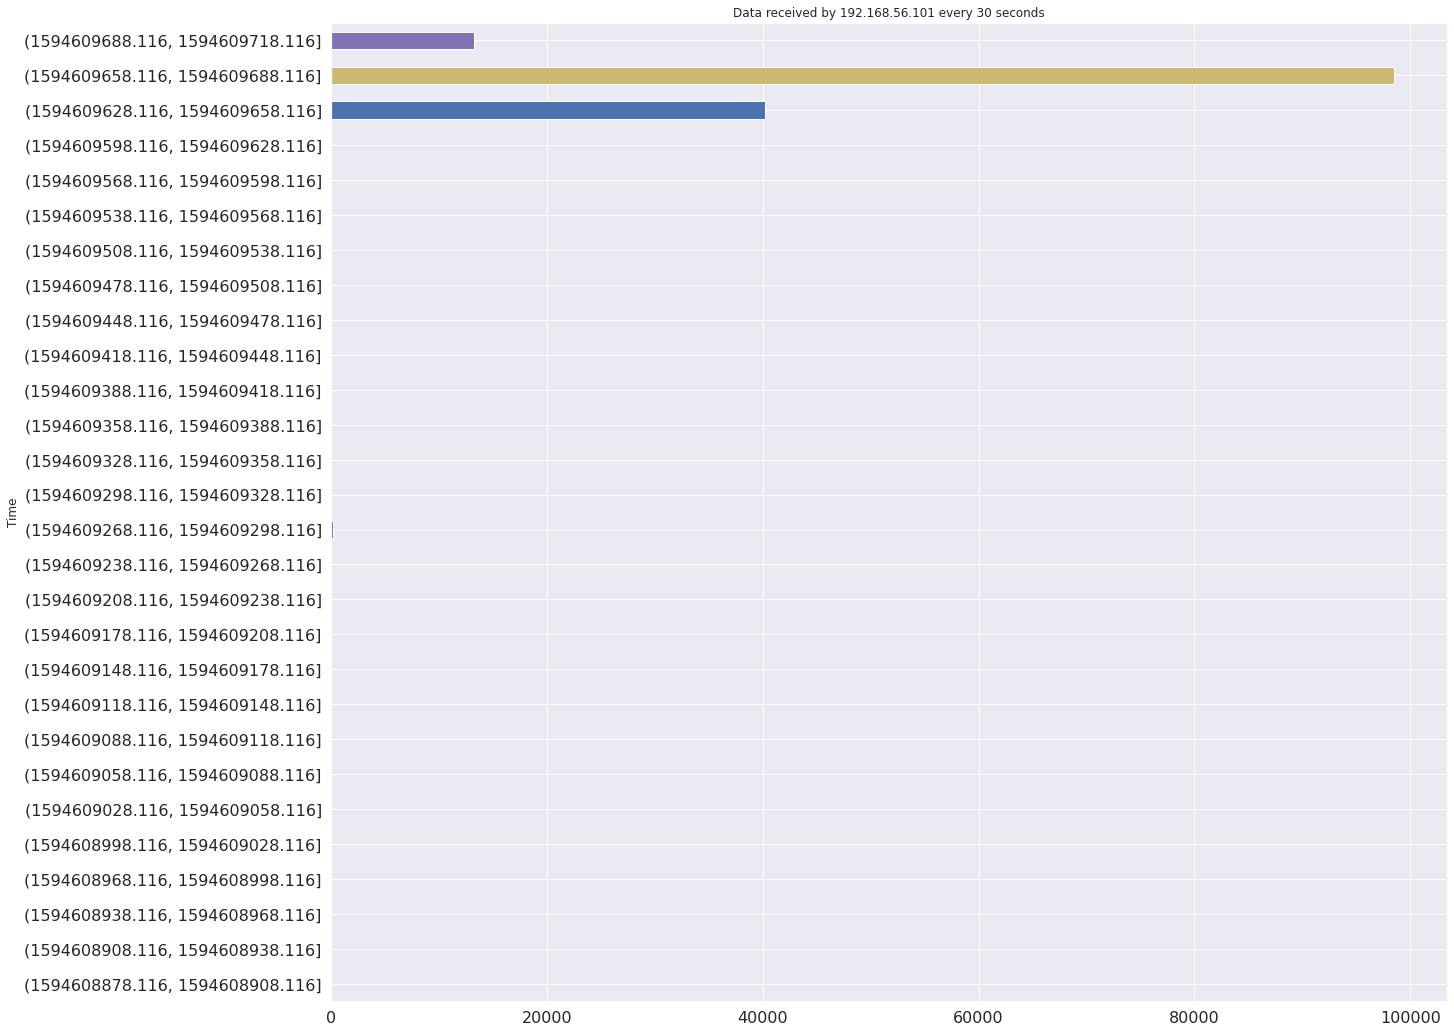

In [20]:
#groupby("time")['payload'].sum().plot(kind='barh',title="Destination Ports (Bytes Received)",figsize=(8,5))

time_slice_df = test_df[(test_df['Source'] == "192.168.56.105")
                        & (test_df['Destination'] == "192.168.56.101") & (test_df['Dest Port'] == 22)]
time_slice_df = time_slice_df[["Time", "Length"]]
print(time_slice_df)

start_time = float(1594608878.115614448)
end_time = float(1594609735.745534519)

bins = np.arange(start_time, end_time+1, 30)
time_slice_df = time_slice_df.groupby(pd.cut(time_slice_df['Time'], bins=bins)).Length.sum()
print("Data received by 192.168.56.101 every 30 seconds (on SSH port 22):\n"+str(time_slice_df))
time_slice_df.plot.barh(title="Data received by 192.168.56.101 every 30 seconds",
                        figsize=(20,18), color=["m", "b", "y"], fontsize=16)